# Import the packages

In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression

# Import the dataframe

In [196]:
df: pd.DataFrame = pd.read_csv('../Datasets/trainingdata.csv', sep=',')
df.head()

,leeftijd,dienstperiode,reisafstand,afdeling_Accountant,afdeling_Administratief medewerker,afdeling_BI,afdeling_Boekhouder,afdeling_Business analist,afdeling_Business controller,afdeling_Business development,...,afdeling_Financial controller,afdeling_HR,afdeling_IT,afdeling_Legal,afdeling_Marketing,afdeling_Office manager,afdeling_Project controller,business_unit_Detachering,business_unit_Intern,aantal_geboortes
0,29.0,5,53,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,7.8
1,33.0,6,50,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,11.9
2,42.0,12,53,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,10.9
3,20.0,3,50,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,11.9
4,32.0,4,115,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,10.2


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48849 entries, 0 to 48848
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   leeftijd                            48849 non-null  float64
 1   dienstperiode                       48849 non-null  int64  
 2   reisafstand                         48849 non-null  int64  
 3   afdeling_Accountant                 48849 non-null  bool   
 4   afdeling_Administratief medewerker  48849 non-null  bool   
 5   afdeling_BI                         48849 non-null  bool   
 6   afdeling_Boekhouder                 48849 non-null  bool   
 7   afdeling_Business analist           48849 non-null  bool   
 8   afdeling_Business controller        48849 non-null  bool   
 9   afdeling_Business development       48849 non-null  bool   
 10  afdeling_Credit controller          48849 non-null  bool   
 11  afdeling_Financial controller       48849

In [198]:
target_column = 'dienstperiode'
X, y = df.drop(target_column, axis=1), df[[target_column]]

In [199]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
# for col in cats:
#    X[col] = X[col].astype('category')

In [200]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
# dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
# dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [202]:
# Define hyperparameters
params = {
    "objective": "reg:squarederror",
    "eta": 0.05,  # Learning rate - controls the step size during training
    "max_depth": 8,  # Maximum depth of a tree - controls the complexity of the trees
    "min_child_weight": 5,  # Minimum sum of instance weight needed in a child
    "gamma": 0.1,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.001,  # L1 regularization term on weights
    "reg_lambda": 1.0,  # L2 regularization term on weights
    "n_estimators": 1000,  # Number of boosting rounds or trees
    "early_stopping_rounds": 50,  # Stop training if no improvement in the validation metric after this number of rounds
    "eval_metric": "rmse"  # Evaluation metric to use
}

# Training the XGBoost model
num_boost_round = 1000
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [203]:
# regression coefficients
print('Coefficients: ', model.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, y_test)))

Coefficients:  [[ 4.78671605e-01 -1.57374476e-04 -3.34528410e-01 -8.60016533e-01
  -8.03955415e-02 -9.57959068e-01 -3.13612307e-01  5.20795421e+00
  -5.82817501e-01 -1.71555975e-01 -1.17963069e-01 -1.10499606e-03
  -1.26849060e+00 -4.92055623e-01 -6.83092760e-01 -6.17878915e-01
   1.27351709e+00 -2.64015966e-01  2.64015966e-01  1.73791065e-02]]
Variance score: 0.8111875395341653


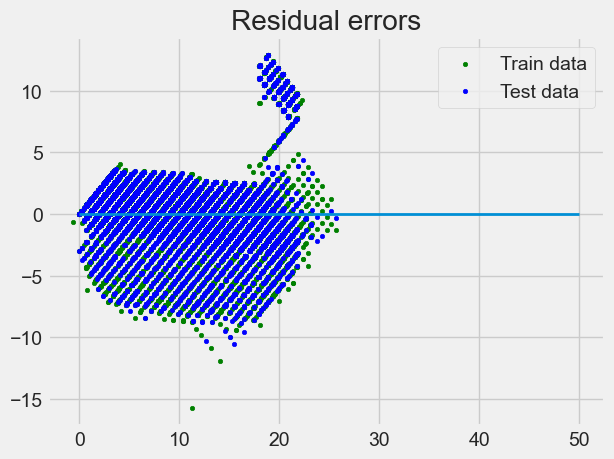

In [204]:
# plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(model.predict(X_train),
            model.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')
 
# plotting residual errors in test data
plt.scatter(model.predict(X_test),
            model.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')
 
# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)
 
# plotting legend
plt.legend(loc='upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

In [205]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

print(model.coef_)
print(model.intercept_)

The r2 is:  0.8111875395341653
The rmse is:  2.8285651768332243
[[ 4.78671605e-01 -1.57374476e-04 -3.34528410e-01 -8.60016533e-01
  -8.03955415e-02 -9.57959068e-01 -3.13612307e-01  5.20795421e+00
  -5.82817501e-01 -1.71555975e-01 -1.17963069e-01 -1.10499606e-03
  -1.26849060e+00 -4.92055623e-01 -6.83092760e-01 -6.17878915e-01
   1.27351709e+00 -2.64015966e-01  2.64015966e-01  1.73791065e-02]]
[-8.68423779]


In [206]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

R-squared: 0.8111875395341653
Mean Squared Error: 8.00078095959357


In [210]:
# Extract coefficients
coefficients = model.coef_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Load the new data
new_data = pd.read_csv('../Datasets/new_data.csv')
result_df = new_data

# Assuming 'target_column' is the target variable
X_new = new_data.drop(target_column, axis=1)
y_true = new_data[target_column]

# Convert categorical columns to the categorical data type
cats = X_new.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X_new[col] = X_new[col].astype('category')

# Create DMatrix with enable_categorical=True
d_new = xgb.DMatrix(X_new, label=y_true, enable_categorical=True)

# Make predictions
predictions = model.predict(d_new)

# Evaluate the model's performance using mean absolute error (MAE)
mae = mean_absolute_error(y_true, predictions)
print(f'Mean Absolute Error: {mae:.2f}')

# # Calculate percentage change
# percentage_change = ((mae - mae_baseline) / mae_baseline) * 100
# print(f'Percentage Change: {percentage_change:.2f}%')


# Convert predicted probabilities to binary predictions (1 or 0)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Create a DataFrame with employee_id and binary predictions
result_df['fired?'] = predictions

# Print or save the result DataFrame
result_df.head(20)

In [ ]:
pickle.dump(model, open('../model.sav', 'wb'))